# Assessment of Tree Detection, Classification, and Geolocation Model
# Density Experiment - Match Predicted Trees to Tree Inventories and Compute RMSE Between Matches

Thomas Lake, December 2024


In [1]:
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import geopandas as gpd
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


In [2]:
# Load datasets: Geolocated trees, Panoramic images, Inventory Trees, and Sampling Grids

In [3]:
# Define city for analyses
city = "WashingtonDC"

In [4]:

# Import .CSV File for Geolocated Trees from Model
geolocated_trees = f"C:/Users/talake2/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_filtered_results_{city}.csv"
geolocated_trees = pd.read_csv(geolocated_trees)

# Convert geolocated trees into a geodataframe
geometry = [Point(xy) for xy in zip(geolocated_trees['longitude'],  geolocated_trees['latitude'])]
geolocated_trees_gdf = gpd.GeoDataFrame(geolocated_trees, geometry=geometry, crs="EPSG:4326")


In [5]:
geolocated_trees_gdf.head()

,Intersection,Pano_ID_1,Pano_Origin_Lon_1,Pano_Origin_Lat_1,Est_Depth_1,Pano_ID_2,Pano_Origin_Lon_2,Pano_Origin_Lat_2,Est_Depth_2,abies_prob,...,triadica_prob,tristaniopsis_prob,tsuga_prob,ulmus_prob,washingtonia_prob,zelkova_prob,geometry,predicted_genus,latitude,longitude
0,POINT (-77.01550613023377 38.87196039496391),---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,7.782004,JbVtvysulOU7pMh25Wm6zQ,-76.938167,38.872206,12.677705,0.000371,...,0.000647,0.000129,0.000199,0.462407,0.003790,0.001417,POINT (-77.01551 38.87196),ulmus,38.871960,-77.015506
1,POINT (-77.01561546546257 38.87199289389718),---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,7.782004,jb_-IKt4rVIwjA05mEvIPw,-76.994631,38.840271,7.636953,0.001052,...,0.000453,0.000377,0.000140,0.838627,0.000537,0.001018,POINT (-77.01562 38.87199),ulmus,38.871993,-77.015615
2,POINT (-77.01565014628315 38.87200320246548),---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,7.782004,T5LI5RrQ570VksiQGnoN5w,-77.004613,38.833881,8.739574,0.000076,...,0.000207,0.000127,0.000112,0.456815,0.000272,0.001448,POINT (-77.01565 38.87200),ulmus,38.872003,-77.015650
3,POINT (-77.01579525319788 38.871984115417334),---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,6.834706,-eA8f-JDNuGAbDe7oFjaxQ,-76.982226,38.885676,5.603208,0.000610,...,0.000184,0.000180,0.000646,0.032227,0.000638,0.000723,POINT (-77.01580 38.87198),quercus,38.871984,-77.015795
4,POINT (-77.0157350518168 38.872129067990485),---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,8.706213,t5O0eymzJcqBx_1W5_nS-Q,-76.950621,38.862844,11.093325,0.000451,...,0.000336,0.000220,0.000387,0.015651,0.001675,0.000847,POINT (-77.01574 38.87213),ailanthus,38.872129,-77.015735


In [6]:

# Import .CSV File for Panoramic Image Locations from 'initial geolocation' file
panos = f"C:/Users/talake2/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_initial_results_{city}.csv"
panos = pd.read_csv(panos)

# Define the bounding box of panoramic images for analysis
bbox = [
    panos['Pano_Origin_Lon'].min() - 0.0003,
    panos['Pano_Origin_Lon'].max() + 0.0003,
    panos['Pano_Origin_Lat'].min() - 0.0003, 
    panos['Pano_Origin_Lat'].max() + 0.0003
]

# Convert panos into a geodataframe
geometry = [Point(xy) for xy in zip(panos['Pano_Origin_Lon'],  panos['Pano_Origin_Lat'])]
panos_gdf = gpd.GeoDataFrame(panos, geometry=geometry, crs="EPSG:4326")


In [7]:
panos_gdf.head()

,Pano_ID,Pano_Origin_Lon,Pano_Origin_Lat,Est_Tree_Lon,Est_Tree_Lat,Predicted_Genus,Pano_Tree_Angle,Est_Depth,Bbox_Area,Bbox_Aspect,...,taxus_prob,thuja_prob,tilia_prob,triadica_prob,tristaniopsis_prob,tsuga_prob,ulmus_prob,washingtonia_prob,zelkova_prob,geometry
0,---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,-77.015677,38.872011,ulmus,110.896162,7.782004,3.744561e+07,1.428131,...,0.000009,0.000019,0.000263,0.000061,0.000063,0.000167,0.907110,0.000387,0.000782,POINT (-77.01576 38.87204)
1,---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,-77.015797,38.871981,quercus,206.804575,6.834706,3.051801e+07,1.097444,...,0.000053,0.000030,0.000375,0.000078,0.000075,0.000482,0.007385,0.000928,0.000594,POINT (-77.01576 38.87204)
2,---1YZiWvW95Kmejk6tAcg,-77.015761,38.872036,-77.015740,38.872113,ailanthus,12.467988,8.706213,2.005622e+07,1.032625,...,0.000269,0.000085,0.000578,0.000500,0.000374,0.000609,0.031055,0.002767,0.001568,POINT (-77.01576 38.87204)
3,--9KYCtVcjH5ECjZLhKOew,-76.954883,38.866996,-76.954867,38.866924,ulmus,170.831399,8.186305,3.584074e+07,1.111979,...,0.000272,0.000445,0.000799,0.000158,0.001679,0.000476,0.230155,0.000210,0.005110,POINT (-76.95488 38.86700)
4,--9KYCtVcjH5ECjZLhKOew,-76.954883,38.866996,-76.954980,38.867068,nyssa,313.635206,11.617563,5.403377e+06,0.770105,...,0.000088,0.000399,0.000284,0.000181,0.000526,0.001302,0.000539,0.000227,0.001107,POINT (-76.95488 38.86700)


In [8]:

# Import .CSV File for Tree Inventory from Autoarborist filtered by the density sampling grids
inventory_trees = f"C:/Users/talake2/Desktop/tree-geolocation-exp/sampled_density_grids_autoarborist_join_inventory_cities/aa_100genera/{city}_aa_100genera_merged_w_sampledgrids.csv"
tree_inventory = pd.read_csv(inventory_trees)

# Convert tree_inventory to a geodataframe
geometry = [Point(xy) for xy in zip(tree_inventory['longitude'],  tree_inventory['latitude'])]
tree_inventory_gdf = gpd.GeoDataFrame(tree_inventory, geometry=geometry, crs="EPSG:4326")

# Subset tree_inventory by the bounding box
#xmin, xmax, ymin, ymax = bbox
#tree_inventory_gdf = tree_inventory_gdf.cx[xmin:xmax, ymin:ymax]

#drop_cols = ['genus label', 'capture time street img', 'tree center x street img', 'tree center y street img']
#tree_inventory_gdf = tree_inventory_gdf.drop(columns = drop_cols)

# Output basic summary statistics of dataset
print(f'There are {tree_inventory_gdf.shape[0]} trees in the {city} inventory and {geolocated_trees_gdf.shape[0]} predicted trees')


There are 3322 trees in the WashingtonDC inventory and 18329 predicted trees


In [9]:
tree_inventory_gdf.head()

,tree id,tree location idx,city,latitude,longitude,genus,genus label,capture time street img,tree center x street img,tree center y street img,dataset type,id.y,test_tree_count,full_tree_count,density_level,grid_id,geometry
0,3868831257314898251,7dbc5f6f-5e36-3976-9b2b-1ee2fc2d6010,washingtondc,38.839962,-77.004684,prunus,235,June 2018,503,576,test,4,19,20,High Density,277,POINT (-77.00468 38.83996)
1,7697639642388007280,f4cfad4b-99c8-3ebf-a2ed-f6249b3f143d,washingtondc,38.840195,-76.996420,zelkova,324,October 2018,475,576,test,14,26,26,High Density,242,POINT (-76.99642 38.84020)
2,2900722775388696920,37eb8589-4878-3656-b678-9a95012be858,washingtondc,38.878360,-77.001090,platanus,227,June 2019,544,576,test,18,29,29,High Density,294,POINT (-77.00109 38.87836)
3,777684137256168215,d9c9ef14-397e-3e42-848c-838caa3bd511,washingtondc,38.855360,-76.987720,amelanchier,15,August 2018,505,576,test,23,9,9,Medium Density,184,POINT (-76.98772 38.85536)
4,17326704671624345885,526be2b7-d056-3658-874f-3bd21fb0d9b6,washingtondc,38.842762,-76.999450,acer,4,June 2019,315,576,test,32,17,17,High Density,305,POINT (-76.99945 38.84276)


In [10]:

# Import City Grid Polygons Sampled for Tree Inventories Based on Density Quantiles
sampled_grids = f"C:/Users/talake2/Desktop/tree-geolocation-exp/output_grids_sampled_tree_inventories_density/sampled_grids/{city}_sampled_grid.geojson"

# Read the GeoJSON file with sampled grids
sampled_grids_gdf = gpd.read_file(sampled_grids)

# Convert to EPSG 4326 CRS
sampled_grids_gdf = sampled_grids_gdf.to_crs("EPSG:4326")

# Check the first few rows of the GeoDataFrame
print(sampled_grids_gdf.tail())

# Get information on one sampled grid
#sampled_grids_gdf.iloc[0]
sampled_grids_gdf.iloc[0].geometry.bounds


     test_tree_count  full_tree_count density_level  \
301               29               29  High Density   
302               18               20  High Density   
303               20               20  High Density   
304               17               17  High Density   
305               22               22  High Density   

                                              geometry  
301  POLYGON ((-76.97644 38.86817, -76.97620 38.869...  
302  POLYGON ((-76.98015 38.84963, -76.97992 38.850...  
303  POLYGON ((-76.96072 38.86026, -76.96049 38.861...  
304  POLYGON ((-76.99865 38.84249, -76.99842 38.843...  
305  POLYGON ((-76.97264 38.84664, -76.97240 38.847...  


(-76.94654356518447, 38.86879501890746, -76.94517178621516, 38.86984701824217)

In [11]:
# Plot Geolocated Trees, Panoramic Images, Tree Inventory, and Sampled Grids

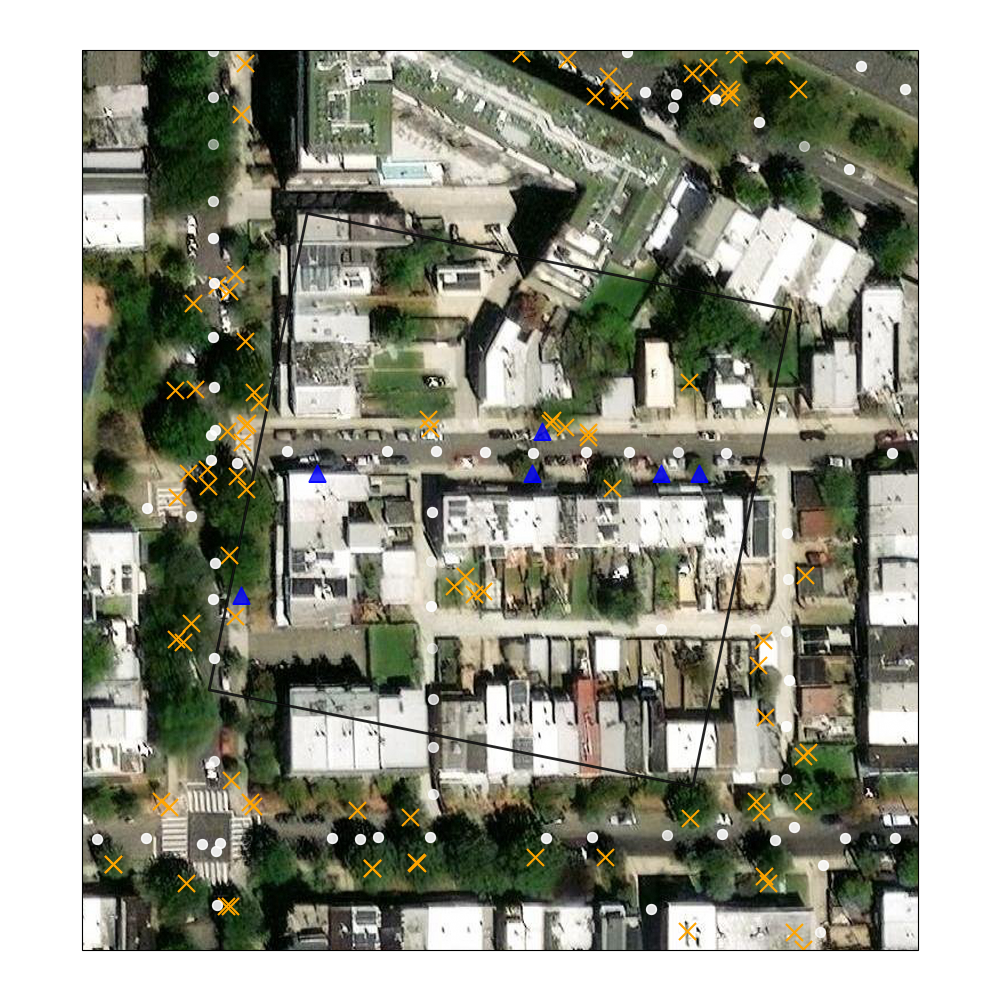

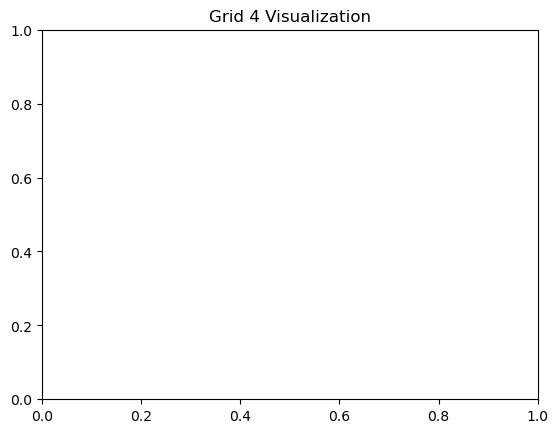

In [12]:
from eomaps import Maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import box
%matplotlib inline

# Select the specific grid index
grid_index = 4 
grid = sampled_grids_gdf.iloc[grid_index]  # Select the grid by index

# Extract the bounding box of the selected grid
grid_bbox = grid.geometry.bounds  # bounds = (minx, miny, maxx, maxy)
bbox = [
    grid_bbox[0] - 0.0003,  # minx with buffer
    grid_bbox[2] + 0.0003,  # maxx with buffer
    grid_bbox[1] - 0.0003,  # miny with buffer
    grid_bbox[3] + 0.0003   # maxy with buffer
]

# Create a map for the current grid
m = Maps(crs=Maps.CRS.Mercator.GOOGLE, figsize=(10, 10))
m.set_extent((bbox[0], bbox[1], bbox[2], bbox[3]))

# Add the grid as a highlighted bounding box
grid_bbox_poly = box(*grid_bbox)
m.add_gdf(sampled_grids_gdf, facecolor='none', edgecolor='grey', linewidth=1, alpha=0.8, label="Sampling Grids")
m.add_gdf(
    sampled_grids_gdf.loc[[grid_index]], facecolor='none', edgecolor='black', linewidth=2, alpha=0.8, label="Current Grid"
)

# Add geolocated trees, panos, and inventory trees
m.add_gdf(geolocated_trees_gdf, marker='x', color='orange', alpha=1, markersize=150, label='Geolocated Trees')
m.add_gdf(panos_gdf, marker='o', color='white', alpha=0.5, markersize=50, label='Panoramic Images')
m.add_gdf(tree_inventory_gdf, marker='^', color='blue', alpha=0.8, markersize=150, label='Tree Inventory')

# Add base layer
m.add_wms.ESRI_ArcGIS.SERVICES.World_Imagery.add_layer.xyz_layer()

# Display the map
plt.title(f"Grid {grid_index} Visualization")
m.show()


# Experiments with Greedy Genus Matching Tree Inventories and Predictions

In [13]:
# Greedy Genus Matching Between Tree Inventory and Geolocated Trees

In [14]:
# Adjusted code to perform nearest neighbor calculations for both matched and unmatched trees
def greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15):
    """
    Perform genus-prioritized greedy matching and calculate nearest neighbor distances for both matched and unmatched trees.
    Args:
        tree_inventory_gdf (gpd.GeoDataFrame): Ground truth tree locations with 'Genus' column.
        geolocated_trees_gdf (gpd.GeoDataFrame): Predicted tree locations with 'predicted_genus' column.
        sampled_grids_gdf (gpd.GeoDataFrame): Grids defining spatial sampling areas.
        max_distance (float): Maximum distance to consider a match as valid (in meters).
    Returns:
        list of dict: Matching results, including genus matches, distances, and nearest neighbors for all trees.
    """
    results = []

    def calculate_distance(p1, p2):
        return geodesic((p1.y, p1.x), (p2.y, p2.x)).meters

    # Iterate across sampling grids
    for _, grid_row in sampled_grids_gdf.iterrows():
        grid = grid_row.geometry
        grid_density_level = grid_row['density_level']
        
        # Subset tree inventory and predicted tree points by the density grid
        tree_inventory_in_grid = tree_inventory_gdf[tree_inventory_gdf.intersects(grid)]
        geolocated_trees_in_grid = geolocated_trees_gdf[geolocated_trees_gdf.intersects(grid)]
        panos_in_grid = panos_gdf[panos_gdf.intersects(grid)]

        # Skip grid if there are no geolocated trees in this grid
        if geolocated_trees_in_grid.empty:
            continue
        
        matches = []
        unmatched_trees = []
        genus_matches_count = 0
        neighbor_distances = []

        # Iterate across trees in the inventory
        for idx1, tree1 in tree_inventory_in_grid.iterrows():
            genus_match_tree = None
            genus_match_dist = float('inf')

            # Check for genus match within max distance
            for idx2, tree2 in geolocated_trees_in_grid.iterrows():
                dist = calculate_distance(tree1.geometry, tree2.geometry)
                if dist <= max_distance and tree1['genus'] == tree2['predicted_genus']:
                    if dist < genus_match_dist:
                        genus_match_dist = dist
                        genus_match_tree = idx2

            # Record matches and unmatched trees
            if genus_match_tree is not None:
                matches.append((idx1, genus_match_tree))
                geolocated_trees_in_grid = geolocated_trees_in_grid.drop(genus_match_tree)
                genus_matches_count += 1
            else:
                unmatched_trees.append(idx1)

            # Nearest neighbor analysis for this tree
            tree_coords = np.array([point.coords[0] for point in tree_inventory_in_grid.geometry])
            if len(tree_coords) > 1:
                kdtree = cKDTree(tree_coords)
                nn_distances, _ = kdtree.query(tree1.geometry.coords[0], k=len(tree_coords))
                nn_distances = nn_distances[1:] * 111132  # Exclude the tree itself and convert to meters

                neighbor_distances.append({
                    "inventory_tree_idx": idx1,
                    "is_matched": genus_match_tree is not None,
                    "matched_pred_tree_idx": genus_match_tree,
                    "genus_match_dist": None if genus_match_tree is None else genus_match_dist,
                    "genus_name": tree1['genus'],
                    "num_neighbors": len(nn_distances),
                    "neighbor_distances": nn_distances.tolist(),
                    "min_nn_distance": np.min(nn_distances),
                    "max_nn_distance": np.max(nn_distances),
                    "mean_nn_distance": np.mean(nn_distances),
                })


        results.append({
            "grid_id": grid_row.name,
            "grid_density_level": grid_density_level,
            "num_panos": len(np.unique(panos_in_grid['Pano_ID'])),
            "num_inv_trees": len(tree_inventory_in_grid),
            "num_genus_matches": genus_matches_count,
            "matches_idx": matches,
            "unmatched_tree_idx": unmatched_trees,
            "neighbor_distances": neighbor_distances,
        })

    return results

In [15]:
results = greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15)


In [16]:
# Examine single grid of matching results
results[3]

{'grid_id': 3,
 'grid_density_level': 'Low Density',
 'num_panos': 27,
 'num_inv_trees': 3,
 'num_genus_matches': 0,
 'matches_idx': [],
 'unmatched_tree_idx': [719, 1515, 2023],
 'neighbor_distances': [{'inventory_tree_idx': 719,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'ulmus',
   'num_neighbors': 2,
   'neighbor_distances': [37.56278039633655, 80.60135127348676],
   'min_nn_distance': 37.56278039633655,
   'max_nn_distance': 80.60135127348676,
   'mean_nn_distance': 59.08206583491165},
  {'inventory_tree_idx': 1515,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'ulmus',
   'num_neighbors': 2,
   'neighbor_distances': [43.12437130016877, 80.60135127348676],
   'min_nn_distance': 43.12437130016877,
   'max_nn_distance': 80.60135127348676,
   'mean_nn_distance': 61.862861286827766},
  {'inventory_tree_idx': 2023,
   'is_matched': False,
   'matched_pred_tree_idx': No

In [17]:
# Create an empty list to hold rows from all grids
all_data_rows = []

# Iterate through all grid results
for grid_result in results:
    for neighbor_info in grid_result['neighbor_distances']:
        # Create a row for each tree's neighbor analysis
        row = {
            'grid_id': grid_result['grid_id'],
            'grid_density_level': grid_result['grid_density_level'],
            'grid_num_panos': grid_result['num_panos'],
            'num_inv_trees': grid_result['num_inv_trees'],
            'num_genus_matches': grid_result['num_genus_matches'],
            'proportion_matches': grid_result['num_genus_matches'] / grid_result['num_inv_trees'],
            'inventory_tree_idx': neighbor_info['inventory_tree_idx'],
            'inventory_genus_name': neighbor_info['genus_name'],
            'is_matched': neighbor_info['is_matched'],
            'match_distance': neighbor_info['genus_match_dist'],
            'matched_pred_tree_idx': neighbor_info['matched_pred_tree_idx'],
            'min_nn_distance': neighbor_info['min_nn_distance'],
            'mean_nn_distance': neighbor_info['mean_nn_distance']
        }
        all_data_rows.append(row)

# Convert the collected rows into a DataFrame
df = pd.DataFrame(all_data_rows)

# Display the DataFrame
#print(df)

# Optionally, save the DataFrame to a CSV for further analysis
#df.to_csv(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_tree_greedy_genus_matching_results_dec524.csv', index=False)


# Analysis of Greedy Genus Matching Between Tree Inventory and Tree Predictions

In [2]:
# Read in results of greedy matching across all cities

df = pd.read_csv(r'C:\Users\talake2\Desktop\tree-geolocation-exp\all_city_geolocation_results_greedy_matching_tables_figures\all_cities_tree_greedy_genus_matching_results_dec524.csv')
city = "All_Cities"

C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\135290351.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2", width=0.5)


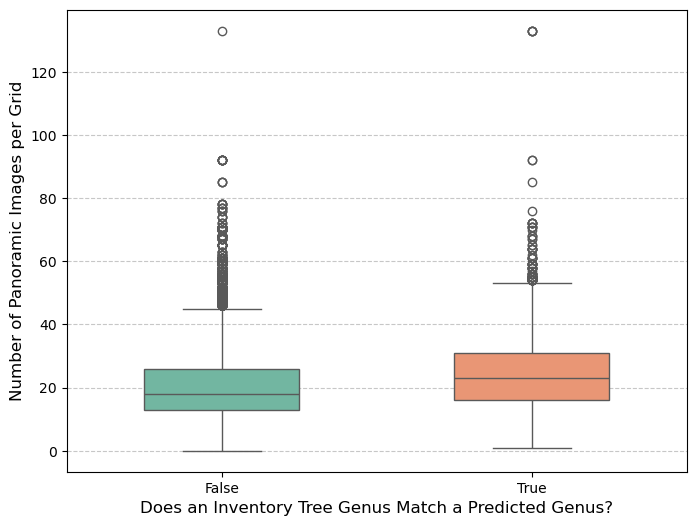

In [46]:
# Does Matching Tree Inventory to Predictions Depend on Number of Panoramic Images in a Grid?

# Create boxplots for 'is_matched' versus 'grid_num_panos'
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2", width=0.5)

# Customize the plot
plt.xlabel("Does an Inventory Tree Genus Match a Predicted Genus?", fontsize=12)
plt.ylabel("Number of Panoramic Images per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_panos_binary_greedy_match.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

In [47]:
# Two-Sample t-test to compare means of two groups

In [48]:
# Average number of panoramic images for matching
mean_values = df.groupby('is_matched')['grid_num_panos'].mean()
print(mean_values)

# Count records for each category in 'is_matched'
counts = df['is_matched'].value_counts()
print(counts)

# Separate the data based on 'is_matched' values
matched_data = df[df['is_matched'] == True]['grid_num_panos']
unmatched_data = df[df['is_matched'] == False]['grid_num_panos']


is_matched
False    20.202034
True     24.668548
Name: grid_num_panos, dtype: float64
False    35494
True      4076
Name: is_matched, dtype: int64


In [49]:
# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(matched_data, unmatched_data)

# Display the results
print(f"T-statistic: {t_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Perform the Shapiro-Wilk test for normality - the data are not normally distributed
_, p_normal_matched = stats.shapiro(matched_data)
_, p_normal_unmatched = stats.shapiro(unmatched_data)

# Display the results
print(f"Shapiro-Wilk test for normality (Matched): p-value = {p_normal_matched:.3f}")
print(f"Shapiro-Wilk test for normality (Unmatched): p-value = {p_normal_unmatched:.3f}")

# If the data is not normally distrubted, use the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(matched_data, unmatched_data)

# Display the result (sig
print(f"U-statistic: {u_stat:.6f}")
print(f"P-value: {p_value_u:.6f}")


T-statistic: 25.711276
P-value: 0.000000
Shapiro-Wilk test for normality (Matched): p-value = 0.000
Shapiro-Wilk test for normality (Unmatched): p-value = 0.000
U-statistic: 89760838.500000
P-value: 0.000000


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [3]:
# Remove NA cases with no matches for plotting
df = df.dropna()


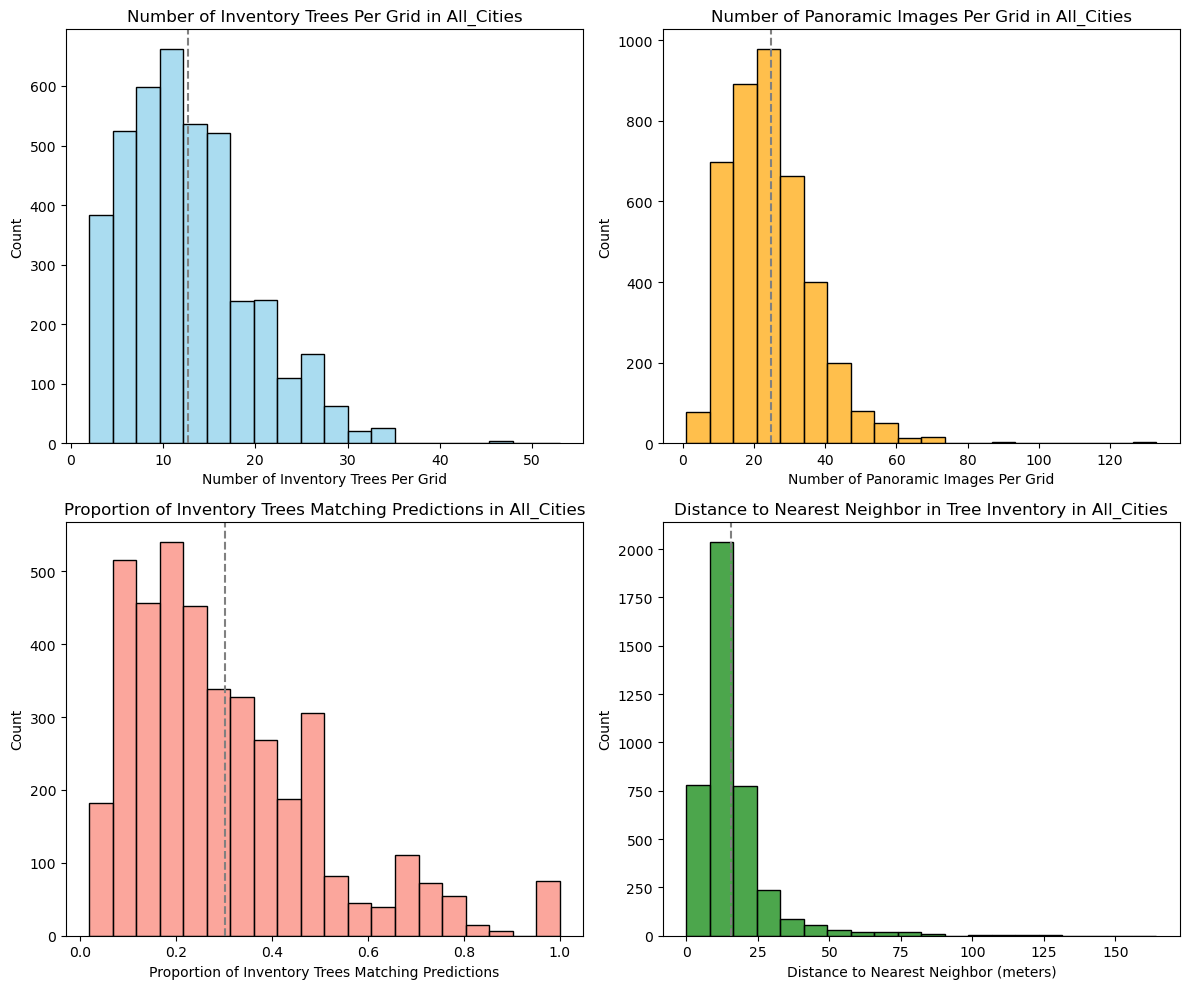

In [52]:
# Summary histograms

# Create a figure to contain the histograms
plt.figure(figsize=(12, 10))

# Plot histograms for each of the variables
plt.subplot(2, 2, 1)
sns.histplot(df['num_inv_trees'], kde=False, color='skyblue', bins=20, alpha=0.7)
plt.axvline(df['num_inv_trees'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Number of Inventory Trees Per Grid in {city}')
plt.xlabel('Number of Inventory Trees Per Grid')

plt.subplot(2, 2, 2)
sns.histplot(df['grid_num_panos'], kde=False, color='orange', bins=20, alpha=0.7)
plt.axvline(df['grid_num_panos'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Number of Panoramic Images Per Grid in {city}')
plt.xlabel('Number of Panoramic Images Per Grid')

plt.subplot(2, 2, 3)
sns.histplot(df['proportion_matches'], kde=False, color='salmon', bins=20, alpha=0.7)
plt.axvline(df['proportion_matches'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Proportion of Inventory Trees Matching Predictions in {city}')
plt.xlabel('Proportion of Inventory Trees Matching Predictions')

plt.subplot(2, 2, 4)
sns.histplot(df['min_nn_distance'], kde=False, color='green', bins=20, alpha=0.7)
plt.axvline(df['min_nn_distance'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Distance to Nearest Neighbor in Tree Inventory in {city}')
plt.xlabel('Distance to Nearest Neighbor (meters)')

# Adjust layout
plt.tight_layout()

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_histograms_trees_panos_matches_distances.png', dpi=300, bbox_inches='tight', format='png')

plt.show()


C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\3707086727.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='grid_density_level', y='num_inv_trees', palette='Set2', width=0.5)


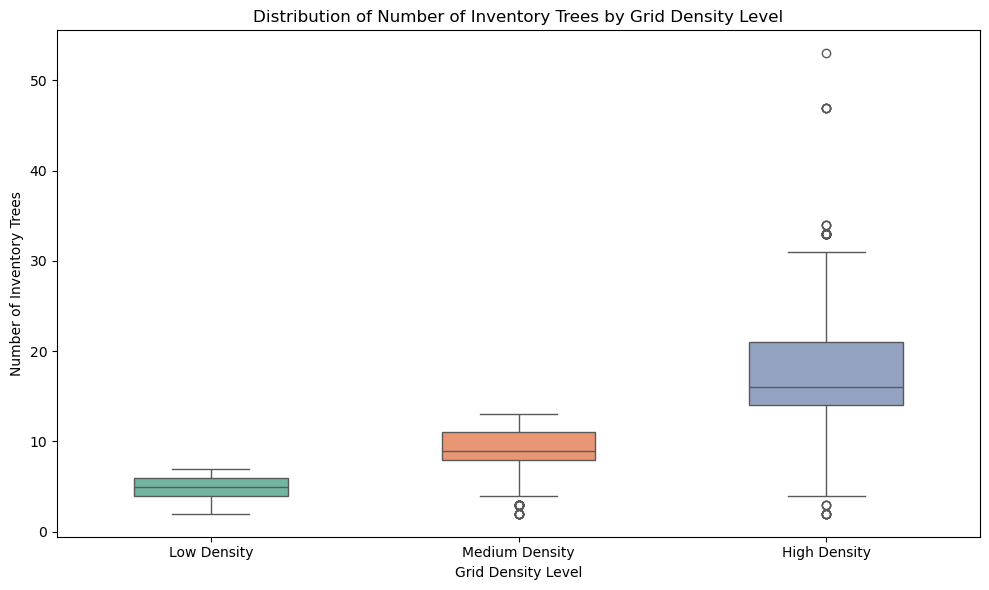

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='grid_density_level', y='num_inv_trees', palette='Set2', width=0.5)

# Add titles and labels
plt.title('Distribution of Number of Inventory Trees by Grid Density Level')
plt.xlabel('Grid Density Level')
plt.ylabel('Number of Inventory Trees')
plt.tight_layout()

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_inv_trees_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')

plt.show()


C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\1352032661.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2", width=0.5)


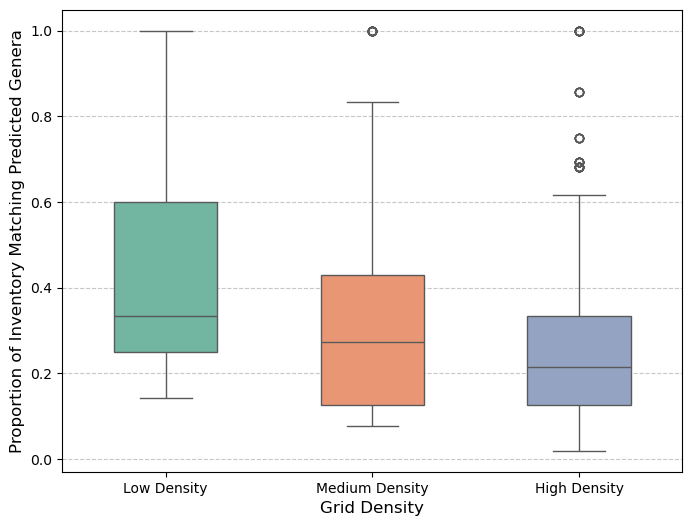

In [54]:

# Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus

plt.figure(figsize=(8, 6))
sns.boxplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2", width=0.5)

# Customize the plot
plt.xlabel("Grid Density", fontsize=12)
plt.ylabel("Proportion of Inventory Matching Predicted Genera", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_proportion_matches_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

In [5]:
from scipy import stats

# Separate the data based on 'grid_density_level'
low_density = df[df['grid_density_level'] == 'Low Density']['proportion_matches']
med_density = df[df['grid_density_level'] == 'Medium Density']['proportion_matches']
high_density = df[df['grid_density_level'] == 'High Density']['proportion_matches']

# Perform One-Way ANOVA
f_stat, p_value = stats.f_oneway(low_density, med_density, high_density)

# Display the results
print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.6f}")


F-statistic: 261.985813
P-value: 0.000000


In [6]:
# Perform Shapiro-Wilk test for normality in each group
_, p_normal_low = stats.shapiro(low_density)
_, p_normal_med = stats.shapiro(med_density)
_, p_normal_high = stats.shapiro(high_density)

# Display normality results
print(f"Shapiro-Wilk test for normality (Low Density): p-value = {p_normal_low:.3f}")
print(f"Shapiro-Wilk test for normality (Medium Density): p-value = {p_normal_med:.3f}")
print(f"Shapiro-Wilk test for normality (High Density): p-value = {p_normal_high:.3f}")


Shapiro-Wilk test for normality (Low Density): p-value = 0.000
Shapiro-Wilk test for normality (Medium Density): p-value = 0.000
Shapiro-Wilk test for normality (High Density): p-value = 0.000


In [7]:
# If data is not normal, use the Kruskal-Wallis test
h_stat, p_value_h = stats.kruskal(low_density, med_density, high_density)

# Display the result
print(f"H-statistic: {h_stat:.3f}")
print(f"P-value: {p_value_h:.3f}")


H-statistic: 411.183
P-value: 0.000


In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit an ANOVA model
model = ols('proportion_matches ~ grid_density_level', data=df).fit()

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['proportion_matches'], groups=df['grid_density_level'], alpha=0.05)

# Display the results
print(tukey.summary())


       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
High Density    Low Density   0.1902   0.0  0.1704  0.2101   True
High Density Medium Density   0.0751   0.0  0.0591  0.0911   True
 Low Density Medium Density  -0.1152   0.0 -0.1365 -0.0939   True
-----------------------------------------------------------------


C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\1174903697.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2", jitter=True, alpha=0.7, size=7)


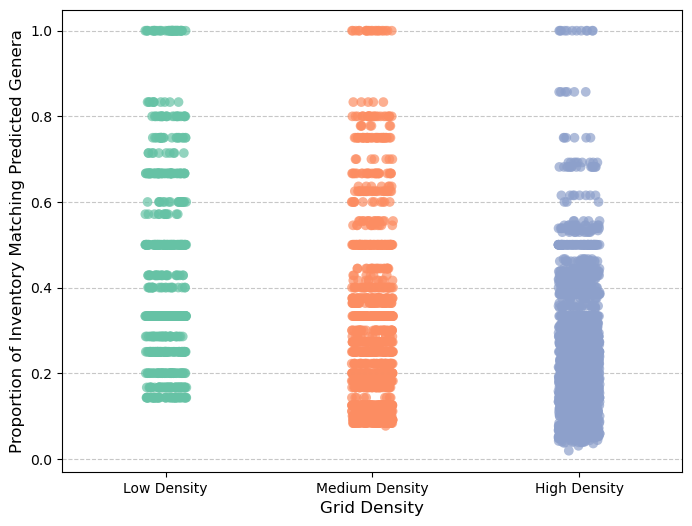

In [55]:

# Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus

plt.figure(figsize=(8, 6))
sns.stripplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2", jitter=True, alpha=0.7, size=7)

# Customize the plot
plt.xlabel("Grid Density", fontsize=12)
plt.ylabel("Proportion of Inventory Matching Predicted Genera", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_stripplots_proportion_matches_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\2894651712.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grid_density_level', y='grid_num_panos', data=df, palette="Set2", width=0.5)


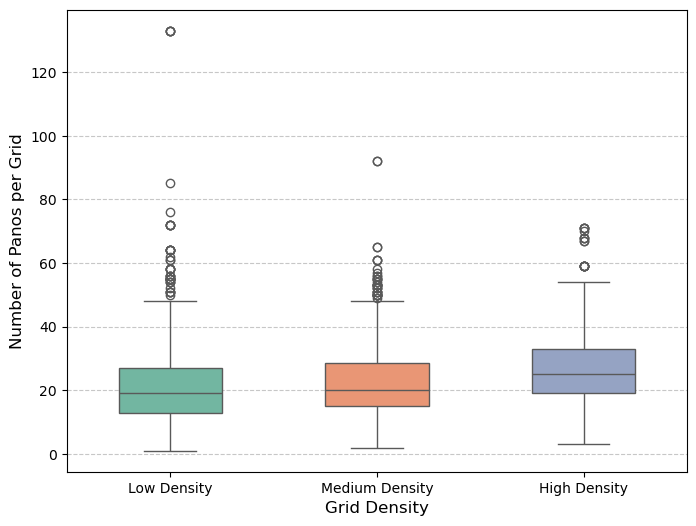

In [56]:

# Boxplots - Relationship between Grid Density and Num. Panos per Grid

plt.figure(figsize=(8, 6))
sns.boxplot(x='grid_density_level', y='grid_num_panos', data=df, palette="Set2", width=0.5)

# Customize the plot
plt.xlabel("Grid Density", fontsize=12)
plt.ylabel("Number of Panos per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_panos_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')


plt.show()

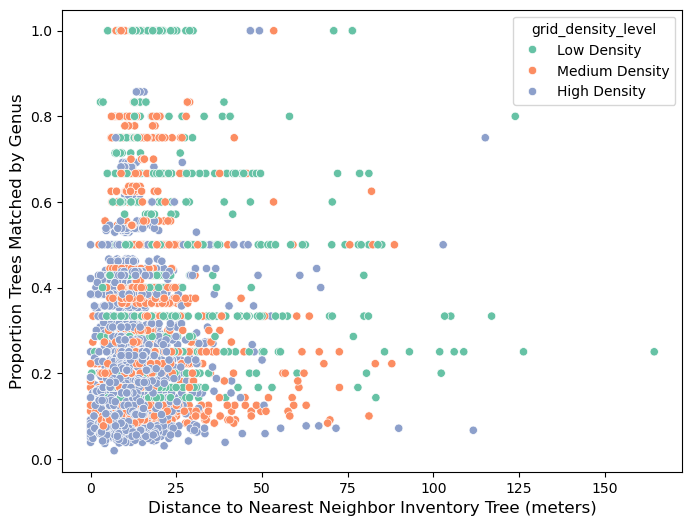

In [57]:

# Scatterplot - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid

plt.figure(figsize=(8, 6))
sns.scatterplot(x='min_nn_distance', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters)", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_scatterplot_proportion_matches_by_nearest_neighbor_density.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

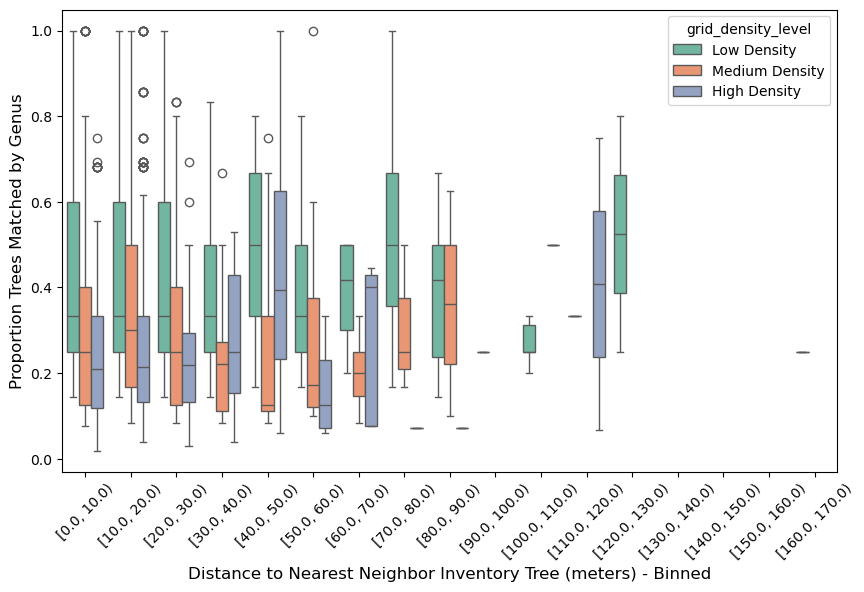

In [59]:
# Boxplots - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['min_nn_distance_bin'] = pd.cut(df['min_nn_distance'], bins=np.arange(0, df['min_nn_distance'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='min_nn_distance_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.xticks(rotation=45)

plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_proportion_matches_by_nearest_neighbor_density_categories.png', dpi=300, bbox_inches='tight', format='png')


plt.show()


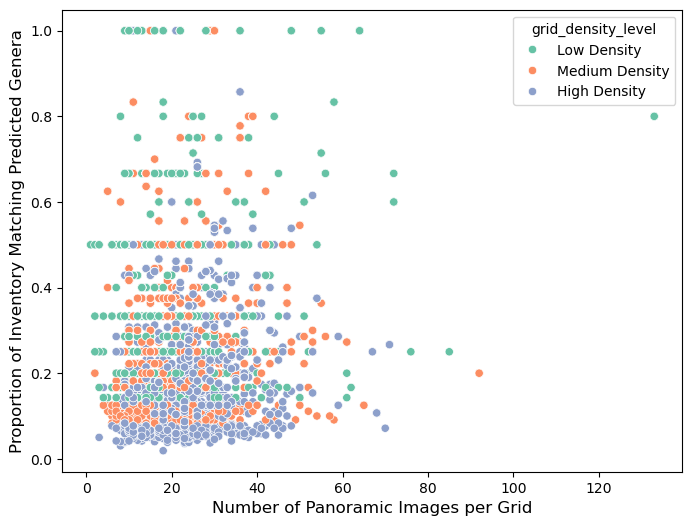

In [63]:

# Scatterplot - Relationship between Num. Panos per Grid and Proportion of Matches by Genus
plt.figure(figsize=(8, 6))
sns.scatterplot(x='grid_num_panos', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid", fontsize=12)
plt.ylabel("Proportion of Inventory Matching Predicted Genera", fontsize=12)

plt.show()

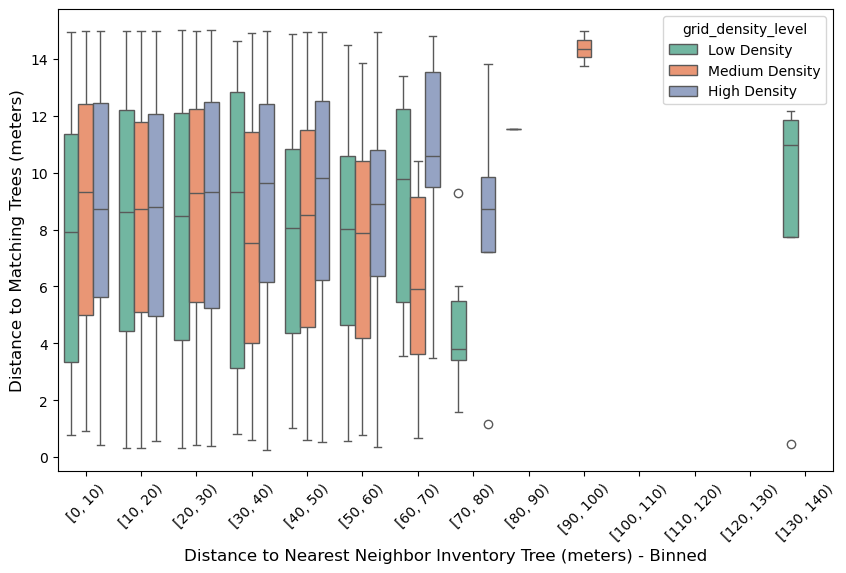

In [61]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='grid_num_panos_bin', y='match_distance', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=12)
plt.ylabel("Distance to Matching Trees (meters)", fontsize=12)

plt.xticks(rotation=45)
plt.show()


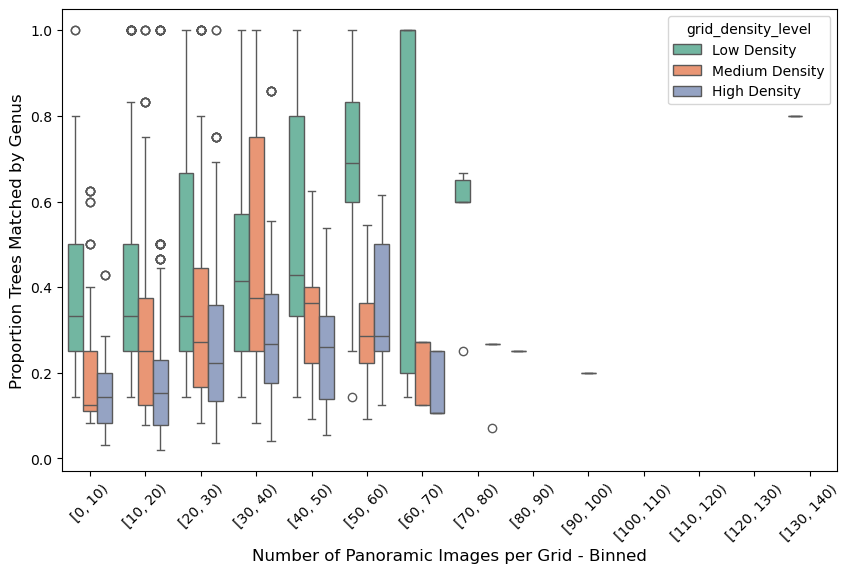

In [62]:
# Boxplots - Relationship between Num. Panos per Grid and Proportion of Matches by Genus

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='grid_num_panos_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid - Binned", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.xticks(rotation=45)
plt.show()


C:\Users\talake2\AppData\Local\Temp\ipykernel_29004\123788044.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


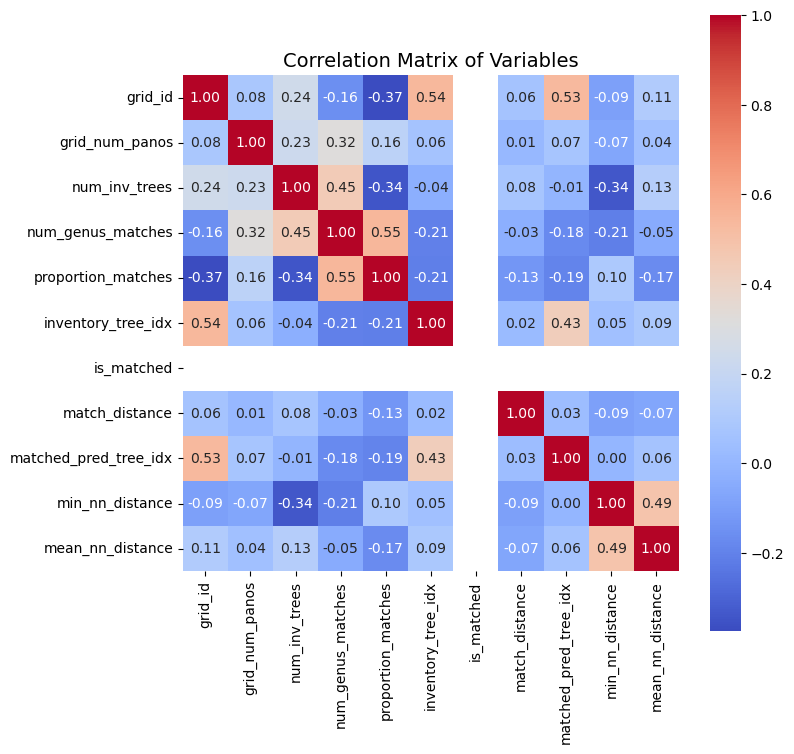

In [60]:
# Calculate the correlation matrix for the numeric variables in `all_data_table`
correlation_matrix = df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)

# Customize the heatmap
plt.title("Correlation Matrix of Variables", fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)

plt.show()


In [ ]:
# Combine results from individual geolocation cities into one dataset
# Directory containing the CSV files
directory = r"C:\Users\talake2\Desktop\tree-geolocation-exp\all_city_geolocation_results_greedy_matching_tables_figures"

# List to store DataFrames
dataframes = []

# Iterate over all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Extract city name from the filename
        city = filename.split('_tree')[0]
        print(city)
        
        # Read the CSV file
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Add a new column for the city
        df['City'] = city
        
        # Append the DataFrame to the list
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a new CSV file
output_file = os.path.join(directory, "all_cities_tree_greedy_genus_matching_results_dec524.csv")
combined_df.to_csv(output_file, index=False)

print(f"Combined file saved to {output_file}")


In [ ]:
# EOF